In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Explore Data

In [99]:
from PIL import Image

def open_image(fname):
    f = fname if fname.endswith('.png') else fname+'.png'
    return Image.open(f'{PATH}/square_lines/{f}')

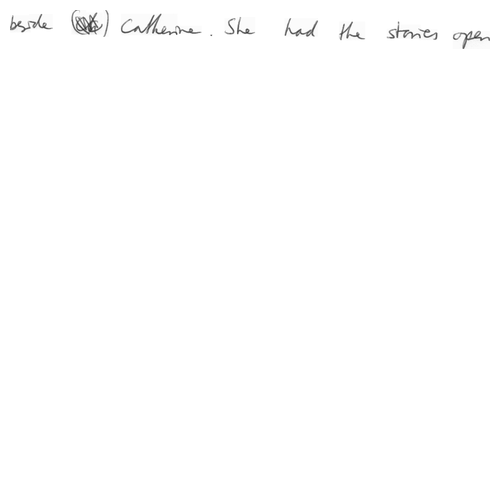

In [100]:
im = open_image('r06-143-01')
im

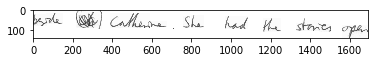

In [116]:
plt.imshow(im)

In [ ]:
new_im = Image.new("RGB", (desired_size, desired_size))

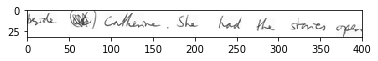

In [9]:
im.thumbnail((400,400), Image.ANTIALIAS)
plt.imshow(im)

In [6]:
line_labels = pd.read_csv(f'{PATH}/ascii/lines.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])

In [7]:
line_labels.tail()

,filename,result,value
13346,r06-143-00,ok,In|the|train|going|back|to|London|I|sat
13347,r06-143-01,ok,beside|#|Catherine|.|She|had|the|stories|open
13348,r06-143-02,ok,"in|front|of|her|,|but|she|said|:|'|Philip|'s|a..."
13349,r06-143-03,ok,I|wish|I|went|to|that|school|.|Did|you|notice
13350,r06-143-04,ok,that|girl|who|said|hullo|to|him|in|the|garden|?


In [8]:
line_labels['text'] = line_labels.apply(lambda row: row.value.replace('|', ' '), axis=1)
line_labels.tail()

,filename,result,value,text
13346,r06-143-00,ok,In|the|train|going|back|to|London|I|sat,In the train going back to London I sat
13347,r06-143-01,ok,beside|#|Catherine|.|She|had|the|stories|open,beside # Catherine . She had the stories open
13348,r06-143-02,ok,"in|front|of|her|,|but|she|said|:|'|Philip|'s|a...","in front of her , but she said : ' Philip 's a..."
13349,r06-143-03,ok,I|wish|I|went|to|that|school|.|Did|you|notice,I wish I went to that school . Did you notice
13350,r06-143-04,ok,that|girl|who|said|hullo|to|him|in|the|garden|?,that girl who said hullo to him in the garden ?


# square images

In [97]:
os.makedirs(PATH/'square_lines', exist_ok=True)

In [98]:
for filename in os.listdir(PATH/FOLDER):
    im=Image.open(PATH/FOLDER/filename)
    im.thumbnail((480,480), Image.ANTIALIAS)
    new_im = Image.new("RGB", (500, 500), color=(255,255,255))
    new_im.paste(im, (10,10))
    new_im.save(PATH/'square_lines'/filename)
    im.close()
    new_im.close()

In [93]:
def square_image(im, sz):
    im.thumbnail((sz-20,sz-20), Image.ANTIALIAS)
    new_im = Image.new("RGB", (sz, sz), color=(255,255,255))
    new_im.paste(im, (10,10))
    new_im.save(PATH/'square_lines'/filename)

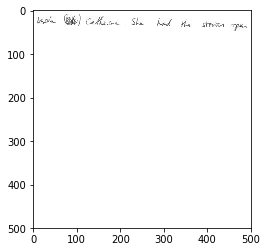

In [101]:
im = open_image('r06-143-01')
plt.imshow(im)

In [96]:
square_image(im, 500)

# Chars

## Setup

In [9]:
chars = set()
for line in line_labels.text:
    chars = chars.union(set(list(line)))
    
len(chars)

79

In [24]:
freq = Counter(char for word in line_labels.text for char in word)
freq.most_common(25)

[(' ', 101872),
 ('e', 56873),
 ('t', 39941),
 ('a', 35819),
 ('o', 33328),
 ('n', 31007),
 ('i', 30280),
 ('s', 27856),
 ('r', 27497),
 ('h', 25230),
 ('l', 18023),
 ('d', 17939),
 ('u', 12197),
 ('c', 11816),
 ('m', 10632),
 ('f', 10004),
 ('w', 8802),
 ('g', 8644),
 ('y', 8259),
 ('p', 8240),
 ('b', 6800),
 ('.', 6207),
 (',', 5617),
 ('v', 4523),
 ('k', 2816)]

In [28]:
itos = [char for char,count in freq.most_common()]
itos.insert(0, '_pad_')
# leave index 1 as ' '
itos.insert(2, '_eos_')
itos.insert(3, '_unk_')
len(itos)

82

In [29]:
joined_labels = list(line_labels.text)

stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word] + [2]) for word in joined_labels])

In [30]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [31]:
line_labels['char_ids'] = str_ids
line_labels.head()

,filename,result,value,text,char_ids
0,a01-000u-00,ok,A|MOVE|to|stop|Mr.|Gaitskell|from,A MOVE to stop Mr. Gaitskell from,33 1 34 50 67 43 1 5 7 1 10 5 7 22 1 34 11 24 ...
1,a01-000u-01,ok,nominating|any|more|Labour|life|Peers,nominating any more Labour life Peers,8 7 17 9 8 6 5 9 8 20 1 6 8 21 1 17 7 11 4 1 4...
2,a01-000u-02,ok,is|to|be|made|at|a|meeting|of|Labour,is to be made at a meeting of Labour,9 10 1 5 7 1 23 4 1 17 6 14 4 1 6 5 1 6 1 17 4...
3,a01-000u-03,err,MPs|tomorrow|.|Mr.|Michael|Foot|has,MPs tomorrow . Mr. Michael Foot has,34 41 10 1 5 7 17 7 11 11 7 19 1 24 1 34 11 24...
4,a01-000u-04,ok,put|down|a|resolution|on|the|subject,put down a resolution on the subject,22 15 5 1 14 7 19 8 1 6 1 11 4 10 7 13 15 5 9 ...


In [34]:
# length of longest string -> seq_len
line_labels.char_ids.map(lambda x: len(x.split(' '))).mean()
# max: 94
# mean: 45

44.222754849823986

In [35]:
# np.save(TMP_PATH/'paragraph_char_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'line_char_itos.pkl', 'wb'))

## CSV

In [5]:
CSV = PATH/'line_chars.csv'
FOLDER = 'square_lines'

csv = pd.read_csv(CSV)
len(csv)

13351

In [6]:
# old_itos = pickle.load(open(TMP_PATH/'line_char_itos.pkl', 'rb'))
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

In [7]:
seq_len = 100
# stats = (np.array([0.92983, 0.92983, 0.92983]), np.array([0.17214, 0.17214, 0.17214]))
stats = (np.array([0.99533, 0.99533, 0.99533]), np.array([0.04573, 0.04573, 0.04573]))  # square

## Convert to char_itos

In [63]:
res = [''.join([itos[int(c)] for c in line[:-15].split(' ')]) for line in csv.char_ids]

In [66]:
stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[char] for char in list(line)]+[3]) for line in res])

In [67]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [20]:
csv.head()

,filename,char_ids
0,a01-000u-00,33 1 34 50 67 43 1 5 7 1 10 5 7 22 1 34 11 24 ...
1,a01-000u-01,8 7 17 9 8 6 5 9 8 20 1 6 8 21 1 17 7 11 4 1 4...
2,a01-000u-02,9 10 1 5 7 1 23 4 1 17 6 14 4 1 6 5 1 6 1 17 4...
3,a01-000u-03,34 41 10 1 5 7 17 7 11 11 7 19 1 24 1 34 11 24...
4,a01-000u-04,22 15 5 1 14 7 19 8 1 6 1 11 4 10 7 13 15 5 9 ...


In [68]:
csv['char_ids'] = str_ids
csv.head()

,filename,char_ids
0,a01-000u-00,30 1 42 44 51 34 1 75 70 1 74 75 70 71 1 42 73...
1,a01-000u-01,69 70 68 64 69 56 75 64 69 62 1 56 69 80 1 68 ...
2,a01-000u-02,64 74 1 75 70 1 57 60 1 68 56 59 60 1 56 75 1 ...
3,a01-000u-03,42 45 74 1 75 70 68 70 73 73 70 78 1 15 1 42 7...
4,a01-000u-04,71 76 75 1 59 70 78 69 1 56 1 73 60 74 70 67 7...


In [70]:
csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

## val idxs

In [8]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

2003

## Calc normalization stats

In [15]:
means = []
stds  = []
for filename in os.listdir(PATH/FOLDER):
    im=Image.open(PATH/FOLDER/filename)
    img = np.array(im)
    means.append(img.mean((0,1)))
    stds.append(img.std((0,1)))
    im.close()
    
means = np.stack(means)
stds = np.stack(stds)

In [16]:
stats = (np.array(means.mean(0)/255), np.array(stds.mean(0)/255))
stats

(array([0.99533, 0.99533, 0.99533]), array([0.04573, 0.04573, 0.04573]))

## Preprocess

In [9]:
f = resnet34
sz = 300
bs = 30

In [10]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
# tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)

data = ImageClassifierData.from_csv(PATH, FOLDER, CSV, bs=bs, val_idxs=val_idxs, tfms=tfms,
                                    continuous=True, suffix='.png')

In [11]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### Verify data loaders

In [28]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [47]:
img = imgs[0,:20,:30,0]  # one channel at a time

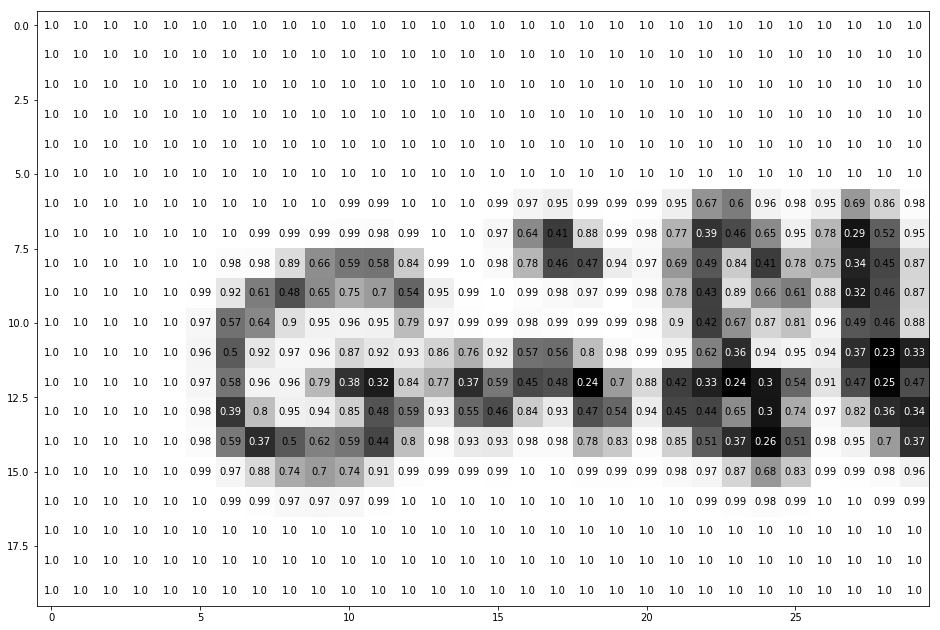

In [50]:
fig = plt.figure(figsize = (16,16)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y].item(),2) if img[x][y].item() !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y].item()<thresh else 'black')

In [40]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
imgs = denorm(x)

In [13]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ' '.join([itos[i] for i in ints])

In [14]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

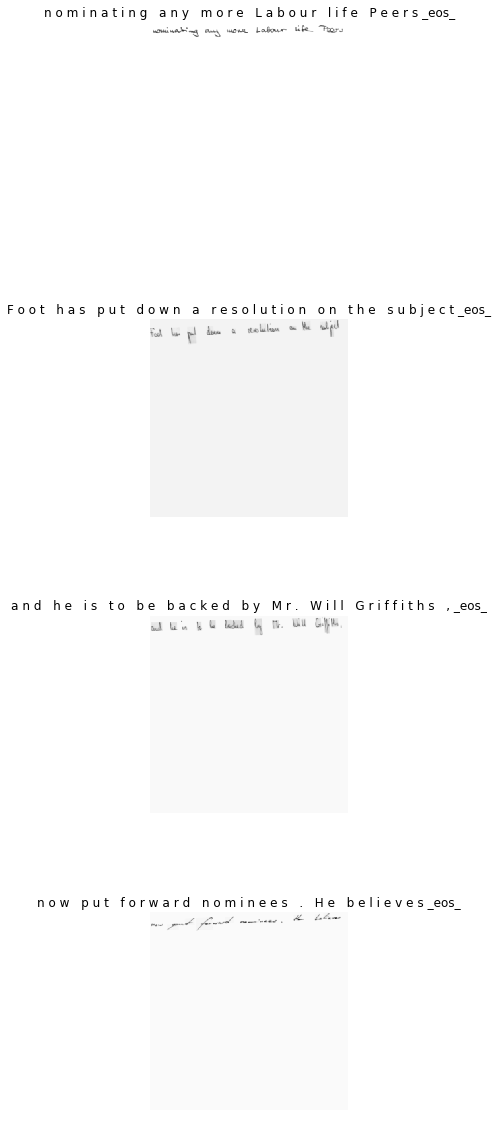

In [18]:
fig, axes = plt.subplots(4,1, gridspec_kw={'hspace': 0.5}, figsize=(20,20))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
    ax=show_img(imgs[i], ax=ax, title=t)

# Loss and Metrics

In [17]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
    if tsl>sl: input = F.pad(input, (0,0,0,0,0,tsl-sl))
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [18]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))/len(w1)

In [19]:
def error_label(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ''.join([itos[i] for i in ints])

def word_error_label(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ' '.join([w_itos[i] for i in ints])

def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = error_label(res[:,i])
        t = error_label(targs[i])
        error += cer(t,p)
    return error/bs

def word_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_error_label(res[:,i])
        t = word_error_label(targs[i])
        error += wer(t,p)
    return error/bs

# Arch

In [41]:
class Base(nn.Module):
    def __init__(self, net):
        super().__init__()

#         slices = {128: -4, 256: -3, 512: -2}
#         s = slices[embed_size]

        modules = list(net.children())[:-4]
        self.base = nn.Sequential(*modules)

    def forward(self, inp):
        return self.base(inp)

In [40]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()
        
        self.linear0 = nn.Linear(128, embed_size)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = inp.flatten(2, 3).permute(2, 0, 1)
        features = self.linear0(features)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [29]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = self.drop(torch.tanh(w1e + w2h))        # ([64, 30, 256])
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [30]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.5):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers, dropout=drop)

    def forward(self, context, hidden):
        out, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return out[-1]

In [31]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.5):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [42]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.base    = Base(f(True))
        self.encoder = Encoder(hidden_size)
        self.attn    = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        self.embed   = nn.Embedding(vocab_size, hidden_size)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(self.base(x))
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.embed(dec_inp)
            
            context, a = self.attn(hidden, feats)
            hidden = self.decoder(context, hidden)
            out = self.output(prev, hidden, context)
            
            if (self.seq_len-i)%50==0: hidden = repackage_var(hidden)

            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            if (dec_inp==0).all(): break

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [43]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), seq_len, 3)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

In [48]:
learn.unfreeze()

# Baseline - resnet/custom head

In [20]:
class Head(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.3):
        super().__init__()
        
        self.pool = nn.AdaptiveMaxPool1d(seq_len)
        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.pool(x.flatten(2,3)).permute(0,2,1)
        x = self.fc2(self.drop(F.relu(self.fc1(x))))
        return x.permute(1,0,2).contiguous()

In [21]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
head = Head(256, seq_len, len(itos))
net = ConvnetBuilder(f, 0, 0, True, custom_head=head, xtra_cut=1).model
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

# Train

 78%|███████▊  | 294/379 [01:16<00:22,  3.83it/s, loss=636]

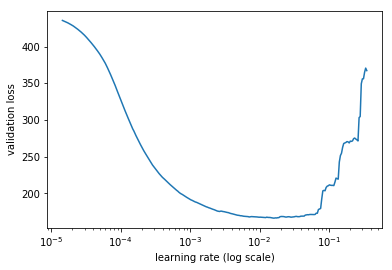

In [22]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 1e-3
learn.fit(lr, 5, cycle_len=1, use_clr_beta=(20,10,0.95,0.85))

# 140.054428 138.753181 0.935897   baseline

epoch      trn_loss   val_loss   char_error_rate           
    0      188.427193 171.996653 0.94974   
    1      176.002219 163.257057 0.954064                  
    2      186.707677 175.900428 0.949877                  
    3      183.852059 237.621425 0.949891                  
 14%|█▍        | 53/379 [00:45<04:42,  1.15it/s, loss=198]

# Results

In [24]:
x,y = next(iter(data.val_dl))
learn.model.eval()
# preds,attns = learn.model(x, ret_attn=True)
preds = learn.model(x)
res = torch.argmax(preds, dim=-1)

seq2seq_loss(preds, y)

tensor(140.1019, device='cuda:0', grad_fn=<DivBackward0>)

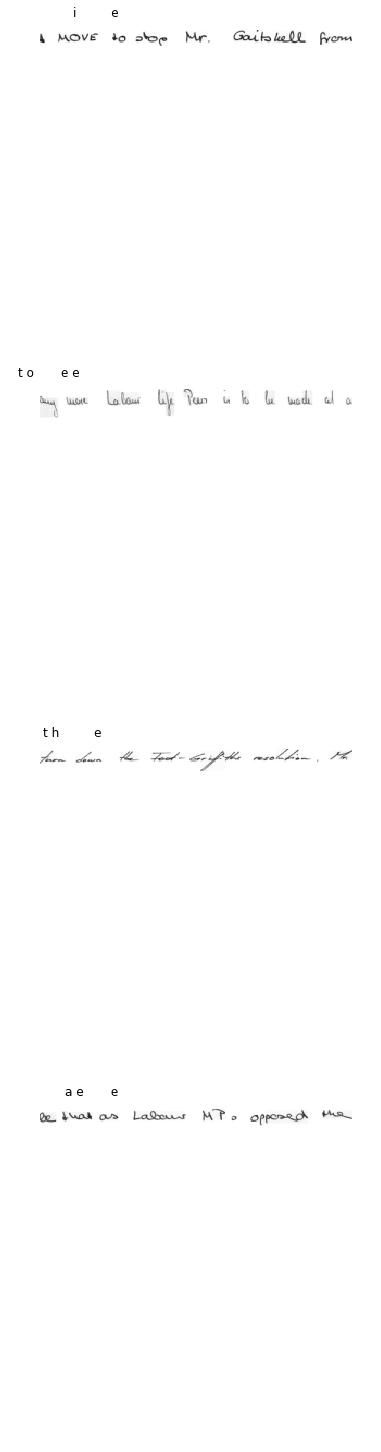

In [27]:
imgs = data.trn_ds.denorm(x)

fig, axes = plt.subplots(4,1, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
#     t = label_text(y[i])     #=>  char indices
    p = label_text(res[:,i])
#     p = ctc_decode(res[:,i])
    ax=show_img(imgs[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)